# Adding river levels
*Developed by R.A. Collenteur & D. Brakenhoff*

In this example it is shown how to create a Pastas model that not only includes precipitation and evaporation, but also observed river levels. We will consider observed heads that are strongly influenced  by river level, based on a visual interpretation of the raw data.

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

ps.show_versions()
ps.set_log_level("INFO")

Python version: 3.9.6 (default, Nov  3 2021, 12:35:15) 
[GCC 9.3.0]
Numpy version: 1.20.1
Scipy version: 1.7.1
Pandas version: 1.2.4
Pastas version: 0.18.0
Matplotlib version: 3.4.2


## 1. import and plot data
Before a model is created, it is generally a good idea to try and visually interpret the raw data and think about possible relationship between the time series and hydrological variables. Below the different time series are plotted.

The top plot shows the observed heads, with different observation frequencies and some gaps in the data. Below that the observed river levels, precipitation and evaporation are shown. Especially the river level show a clear relationship with the observed heads. Note however how the range in the river levels is about twice the range in the heads. Based on these observations, we would expect the the final step response of the head to the river level to be around 0.5 [m/m]. 

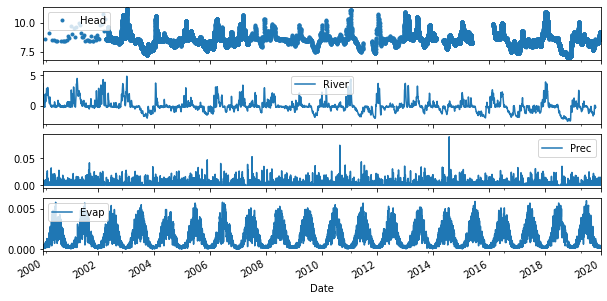

In [3]:
oseries = pd.read_csv(
    "./data/nb5_head.csv", parse_dates=True, squeeze=True, index_col=0
)
rain = pd.read_csv("./data/nb5_prec.csv", parse_dates=True, squeeze=True, index_col=0)
evap = pd.read_csv("./data/nb5_evap.csv", parse_dates=True, squeeze=True, index_col=0)
waterlevel = pd.read_csv(
    "./data/nb5_riv.csv", parse_dates=True, squeeze=True, index_col=0
)

fig, axes = plt.subplots(4, 1, figsize=(10, 5), sharex=True)
oseries.plot(ax=axes[0], x_compat=True, legend=True, marker=".", linestyle=" ")
waterlevel.plot(ax=axes[1], x_compat=True, legend=True)
rain.plot(ax=axes[2], x_compat=True, legend=True)
evap.plot(ax=axes[3], x_compat=True, legend=True)
plt.xlim("2000", "2020")

## 2. Create a timeseries model
First we create a model with precipitation and evaporation as explanatory time series. The results show that precipitation and evaporation can explain part of the fluctuations in the observed heads, but not all of them.

INFO: Cannot determine frequency of series Head: freq=None. The time series is irregular.
INFO: Inferred frequency for time series Prec: freq=D
INFO: Inferred frequency for time series Evap: freq=D
/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pastas/model.py:1658: RuntimeWarning: invalid value encountered in log10
  atol = np.min([1e-8, 10**(np.round(np.log10(pmin)) - 1)])


Fit report River                    Fit Statistics
nfev    17                     EVP           38.60
nobs    5963                   R2             0.39
noise   True                   RMSE           0.46
tmin    2000-01-27 00:00:00    AIC       -30348.84
tmax    2019-10-29 00:00:00    BIC       -30315.38
freq    D                      Obj           18.34
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (5 optimized)
                optimal   stderr     initial  vary
recharge_A   516.647218  ±39.48%  183.785267  True
recharge_a   217.817118  ±38.80%   10.000000  True
recharge_f    -1.594871  ±19.43%   -1.000000  True
constant_d     8.536661   ±3.12%    8.547142  True
noise_alpha   66.997948  ±14.22%    1.000000  True


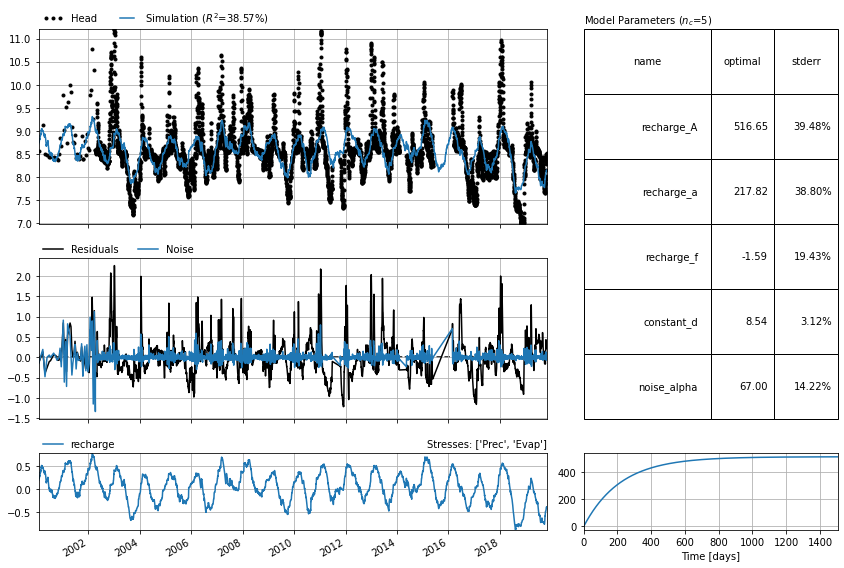

In [4]:
ml = ps.Model(oseries.resample("D").mean().dropna(), name="River")

sm = ps.RechargeModel(rain, evap, rfunc=ps.Exponential, name="recharge")
ml.add_stressmodel(sm)

ml.solve(tmin="2000", tmax="2019-10-29")
ml.plots.results(figsize=(12, 8))

## 3. Adding river water levels
Based on the analysis of the raw data, we expect that the river levels can help to explain the fluctuations in the observed heads. Here, we add a stress model (`ps.StressModel`) to add the rivers level as an explanatory time series to the model. The model fit is greatly improved, showing that the rivers help in explaining the observed fluctuations in the observed heads. It can also be observed how the response of the head to the river levels is a lot faster than the response to precipitation and evaporation.

INFO: Inferred frequency for time series River: freq=D
/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pastas/model.py:1658: RuntimeWarning: invalid value encountered in log10
  atol = np.min([1e-8, 10**(np.round(np.log10(pmin)) - 1)])
/tmp/Python/python-3.9.6/lib/python3.9/site-packages/pastas/model.py:1658: RuntimeWarning: divide by zero encountered in log10
  atol = np.min([1e-8, 10**(np.round(np.log10(pmin)) - 1)])


Fit report River                     Fit Statistics
nfev    17                     EVP           93.39
nobs    5963                   R2             0.93
noise   True                   RMSE           0.15
tmin    2000-01-27 00:00:00    AIC       -39083.24
tmax    2019-10-29 00:00:00    BIC       -39043.08
freq    D                      Obj            4.24
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (6 optimized)
                 optimal   stderr     initial  vary
recharge_A    206.389858  ±23.03%  183.785267  True
recharge_a    166.842367  ±22.57%   10.000000  True
recharge_f     -1.265241  ±16.37%   -1.000000  True
waterlevel_d    0.422350   ±0.73%    1.000000  True
constant_d      8.477314   ±1.00%    8.547142  True
noise_alpha    32.223805  ±10.56%    1.000000  True


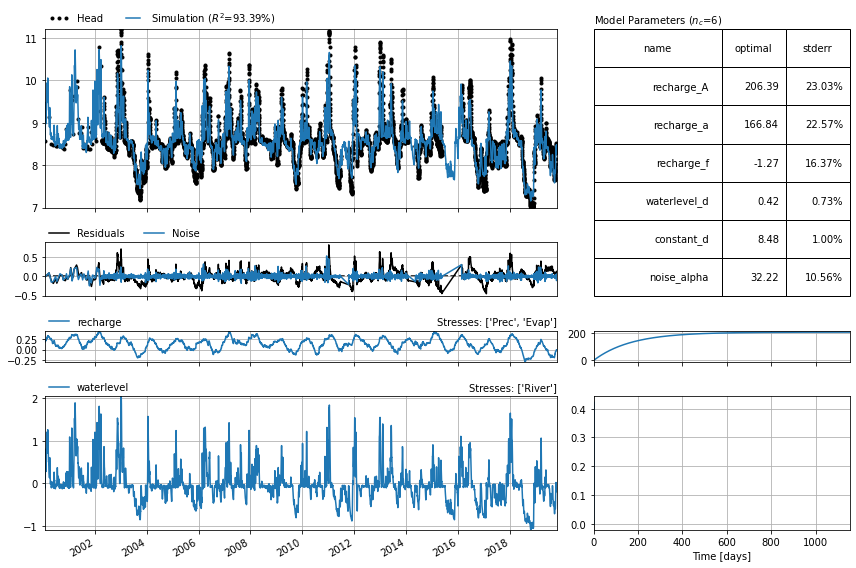

In [5]:
w = ps.StressModel(waterlevel, rfunc=ps.One, name="waterlevel", settings="waterlevel")
ml.add_stressmodel(w)
ml.solve(tmin="2000", tmax="2019-10-29")
axes = ml.plots.results(figsize=(12, 8))
axes[-1].set_xlim(0, 10)
# By default, the axes between responses are shared.